In [2]:
import elephant
from ephysvibe.structures.trials_data import TrialsData
import numpy as np
from ephysvibe.task import task_constants,def_task
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from mne import time_frequency, create_info, EpochsArray

In [3]:
path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-03-06_10-32-51_Riesling_lip_e1_r1.h5'
#2023-01-20_11-00-24_Riesling_lip_e1_r1
#2023-03-07_10-14-11_Riesling_lip_e1_r1
#2023-03-03_10-59-32_Riesling_lip_e1_r1
#2023-03-06_10-32-51_Riesling_lip_e1_r1
#2023-02-08_10-39-41_Riesling_lip_e1_r1

In [4]:
data = TrialsData.from_python_hdf5(path)

In [5]:
def evoked_CSD(lfp, n_channels, inter_channel_distance, step=2):
    csd = []
    for channel in range(0+step,n_channels - step):
        csd.append(
            (-2 * lfp[channel] + lfp[channel- step] + lfp[channel + step]) / ((step * inter_channel_distance) ** 2)
            )
    
    return np.array(csd)

In [6]:
def compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = 1000,w_size = 200):

    if psd_method == 'multitaper':
        psd, freqs = time_frequency.psd_array_multitaper(x,fmax=fmax,sfreq=s_freq)
    elif psd_method == 'welch':
        psd, freqs = time_frequency.psd_array_welch(x,fmax=fmax,sfreq=s_freq,n_per_seg=w_size)
    else:
        print('method should be multitaper or welch')
    # Relative power (RP)
    # Compute the mean power spectrum for each channel (mean across trials)
    avg_psd = psd.mean(axis=(0))
    # Compute the RP
    avg_psd = avg_psd/np.max(avg_psd,axis=0)
    # compute relative power maps
    rp_alpha_beta = avg_psd[:,np.where(np.logical_and(freqs>10,freqs<30))[0]]
    rp_gamma = avg_psd[:,np.where(np.logical_and(freqs>50,freqs<150))[0]]
    return avg_psd,freqs,rp_alpha_beta,rp_gamma

In [7]:
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
trials_s_on = data.code_samples[
    trial_idx,
    np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1["sample_on"])[#target_on
        1
    ],
]
t_before=500
shifts = -(trials_s_on - t_before).astype(int)
shifts = shifts[:,np.newaxis]

In [8]:
shift_lfp = TrialsData.indep_roll(data.lfp_values[trial_idx], shifts, axis=2)
inter_channel_distance=50
step=2
n_channels=shift_lfp.shape[1]
csd=evoked_CSD(shift_lfp.mean(axis=0), n_channels, inter_channel_distance, step=step)

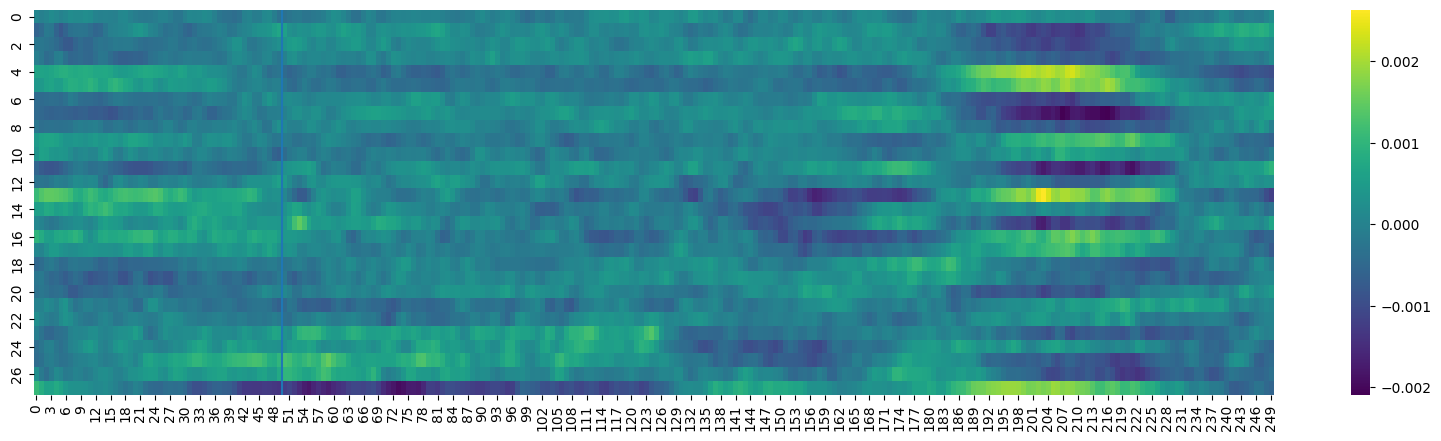

In [9]:
fig, ax = plt.subplots(figsize=(20,5)) 
start_plot =  t_before-50
sns.heatmap(csd[:,start_plot:t_before+200],cmap='viridis',ax=ax)
ax.vlines([t_before-start_plot],0,n_channels-step * 2)

In [32]:
t_before

500

(467, 32, 7841)
(467, 7841)


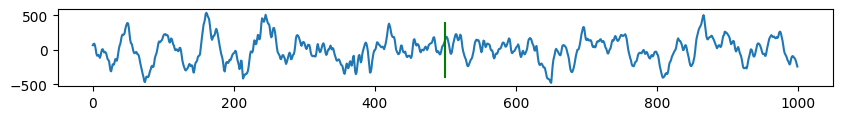

In [35]:
print(shift_lfp.shape)
median_ch = np.median(shift_lfp,axis=1)
print(median_ch.shape)
lfp_median_correction = shift_lfp-median_ch[:,np.newaxis,:]

fig,ax = plt.subplots(figsize=(10,1))
a=ax.plot(median_ch[0,:1000])
ax.vlines([t_before],-400,400,colors=['g'])


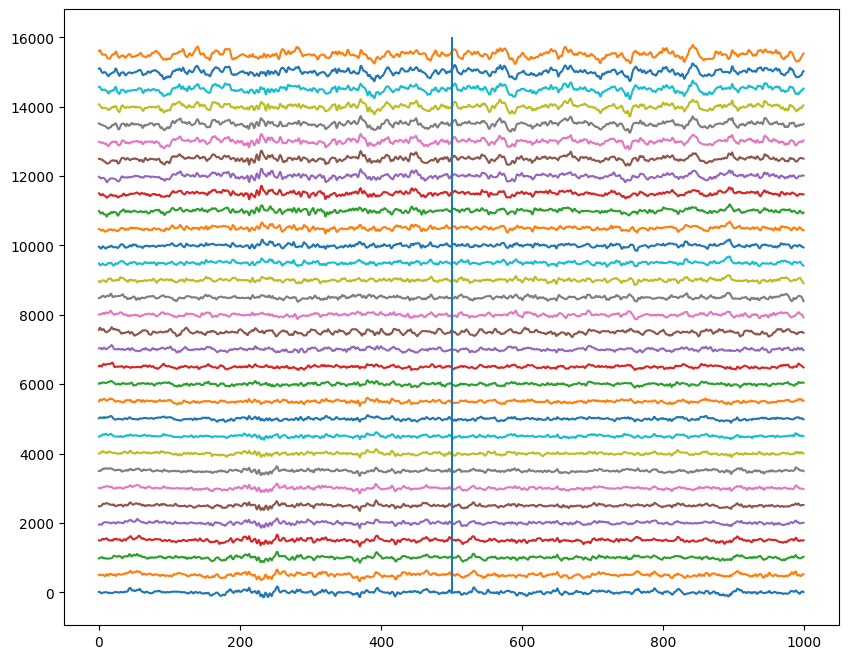

In [11]:

fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(lfp_median_correction[0,:,:1000].T+np.arange(0,32*500,500))
ax.vlines([t_before],0,32*500)

    Using multitaper spectrum estimation with 7 DPSS windows


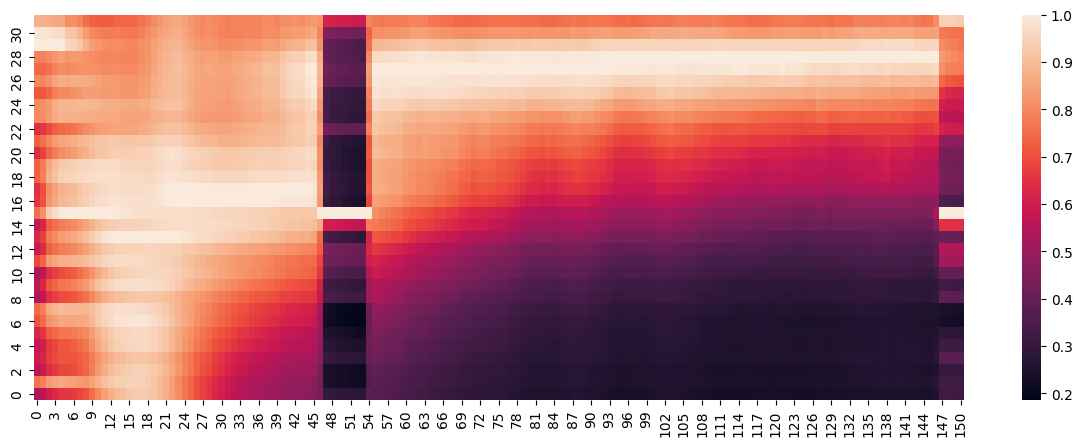

In [18]:
fmax=150
s_freq = 1000
w_size = 200
x=shift_lfp[:,:,:1000]#lfp_median_correction

avg_psd,freqs,rp_alpha_beta,rp_gamma = compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)

# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd)
ax.invert_yaxis()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


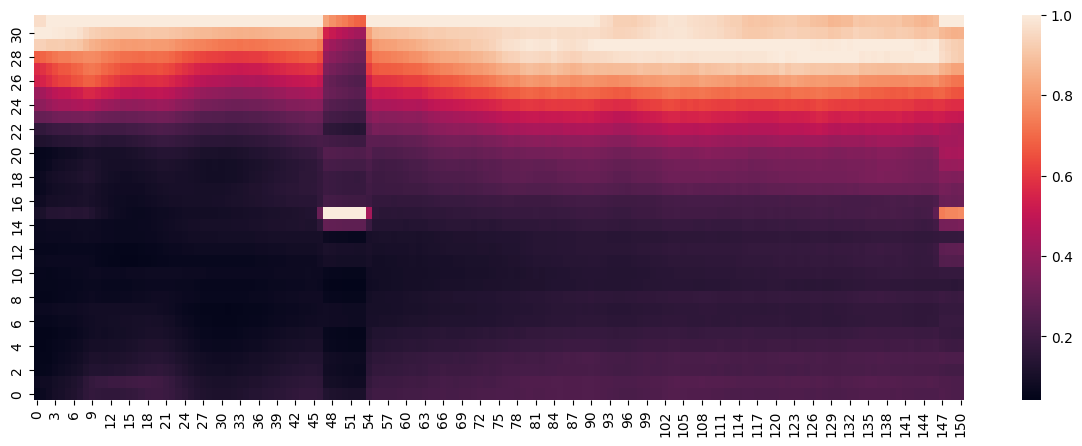

In [19]:
x=lfp_median_correction[:,:,:1000]#

avg_psd_median,freqs_median,rp_alpha_beta_median,rp_gamma_median = compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)

# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd_median)
ax.invert_yaxis()
plt.show()

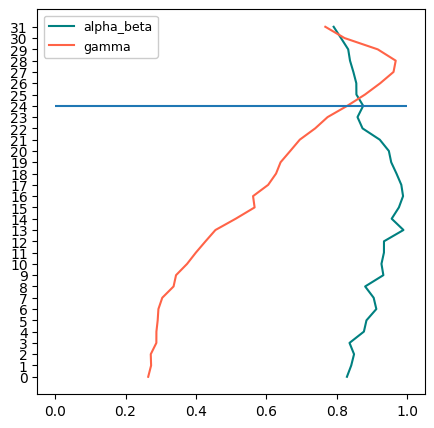

In [14]:
_,ax = plt.subplots(figsize=(5,5))
a=ax.plot(rp_alpha_beta.mean(axis=1),np.arange(0,32),label='alpha_beta',color='teal')
a=ax.plot(rp_gamma.mean(axis=1),np.arange(0,32),label='gamma',color='tomato')
a=ax.set_yticks(np.arange(0,32))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper left')
ax.hlines([24],0,1)

In [15]:
data.clusterdepth

array([ 950., 1000., 1050., 1150., 1200., 1350., 1500., 1450., 1450.,
        900.,  900.])

In [16]:
data.clusters_ch

array([18, 19, 20, 22, 23, 26, 29, 28, 28, 17, 17])

#### Generalized Phase (GP)

In [17]:
from scipy.signal import hilbert, butter, sosfilt
import numpy as np

In [99]:
fs = 1000
order = 8
hp_sos = butter(order, 5, "hp", fs=fs, output="sos")
lp_sos = butter(order, 50, "lp", fs=fs, output="sos")

dat = shift_lfp



dat = sosfilt(hp_sos, dat)
dat = sosfilt(lp_sos, dat)[:,:,:1000]

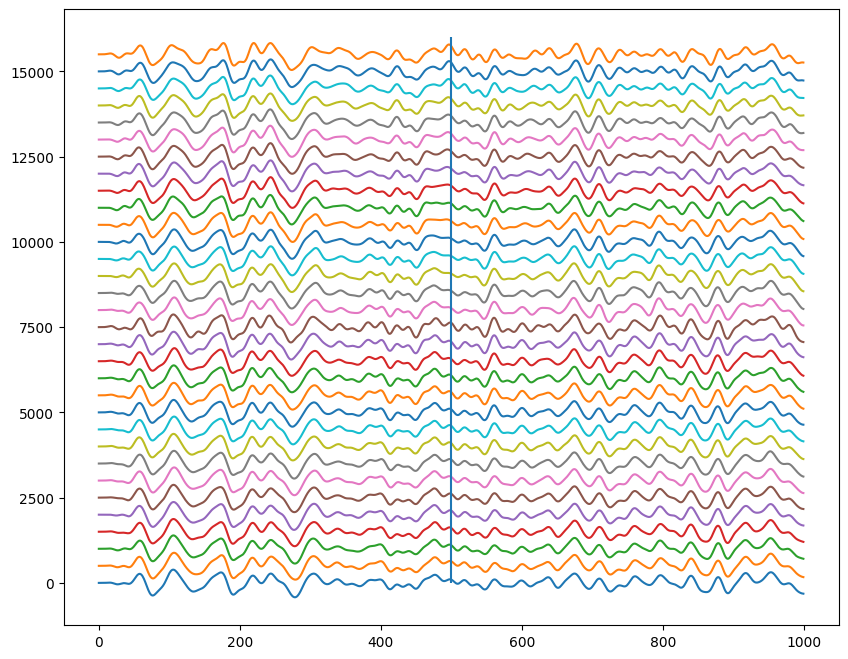

In [100]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(dat[0,:,:1000].T+np.arange(0,32*500,500))
ax.vlines([t_before],0,32*500)

In [101]:
analytical_signal.shape

(467, 32, 1000)

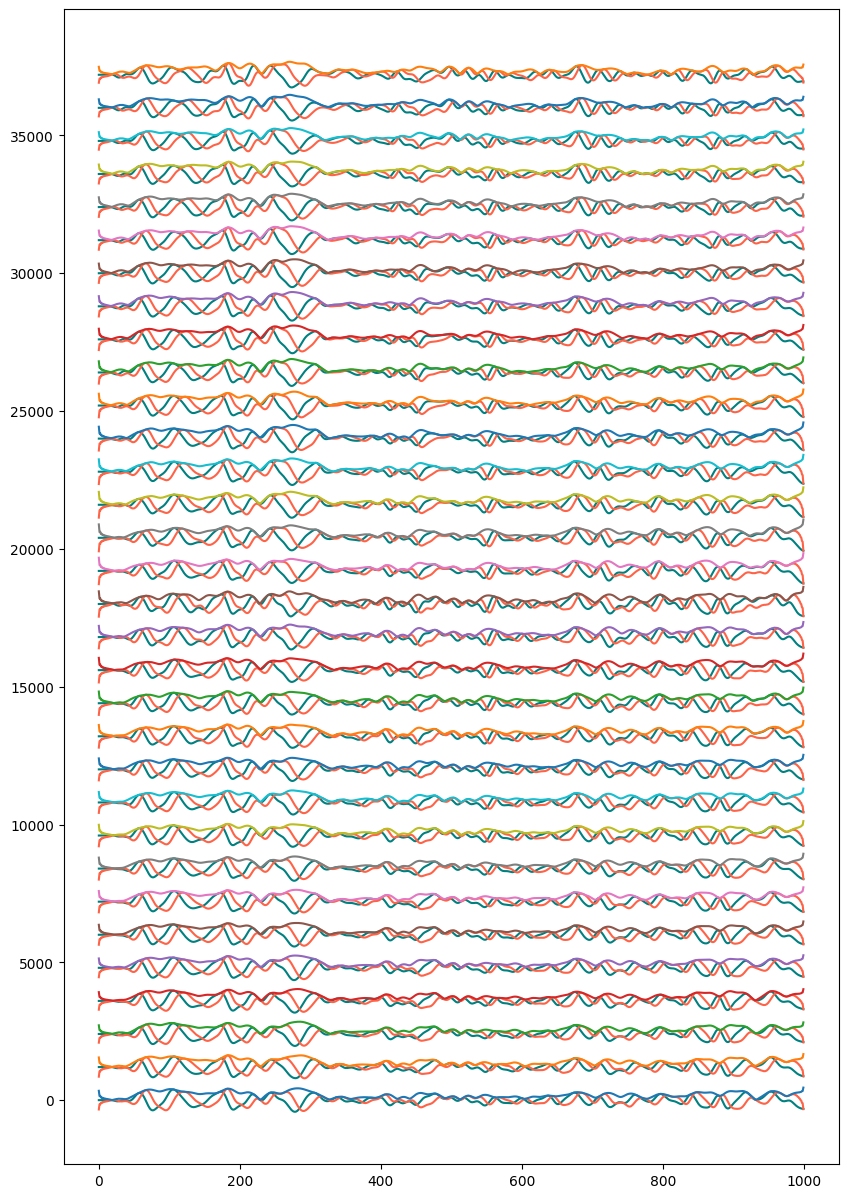

In [102]:


analytical_signal = hilbert(dat)
fig,ax = plt.subplots(figsize=(10,15))
ax.plot(analytical_signal[0].real.T+np.arange(0,32*1200,1200),color='teal')
ax.plot(analytical_signal[0].imag.T+np.arange(0,32*1200,1200),color='tomato')


amplitude_envelope = np.abs(analytical_signal[0])
a=ax.plot(amplitude_envelope.T+np.arange(0,32*1200,1200))

In [103]:
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt


In [104]:
dat.shape

(467, 32, 1000)

In [106]:
yf[0:N//2].shape

(32, 1000)

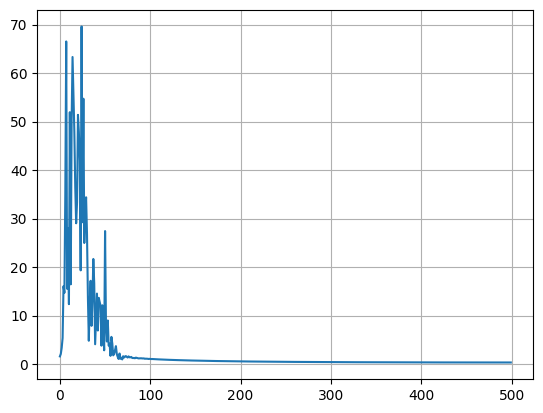

In [107]:
# Number of sample points
N = dat.shape[2]
# sample spacing
fs = 1000
T = 1.0 / fs
x = np.linspace(0.0, N*T, N, endpoint=False)
y = dat[0]
yf = fft(y)
xf = fftfreq(N, T)[:N//2]


plt.plot(xf, 2.0/N * np.abs(yf[0,0:N//2]))
plt.grid()
plt.show()

In [152]:
YF = ifft(yf[0:N//2])

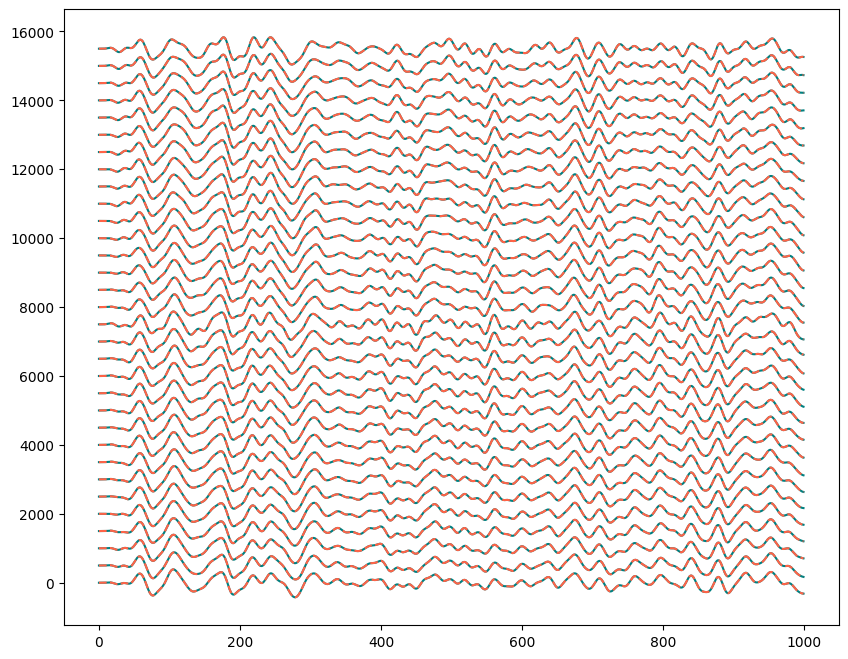

In [153]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(YF.T+np.arange(0,32*500,500),color='teal')
a=ax.plot(dat[0,:,:1000].T+np.arange(0,32*500,500),color='tomato',linestyle = '--')

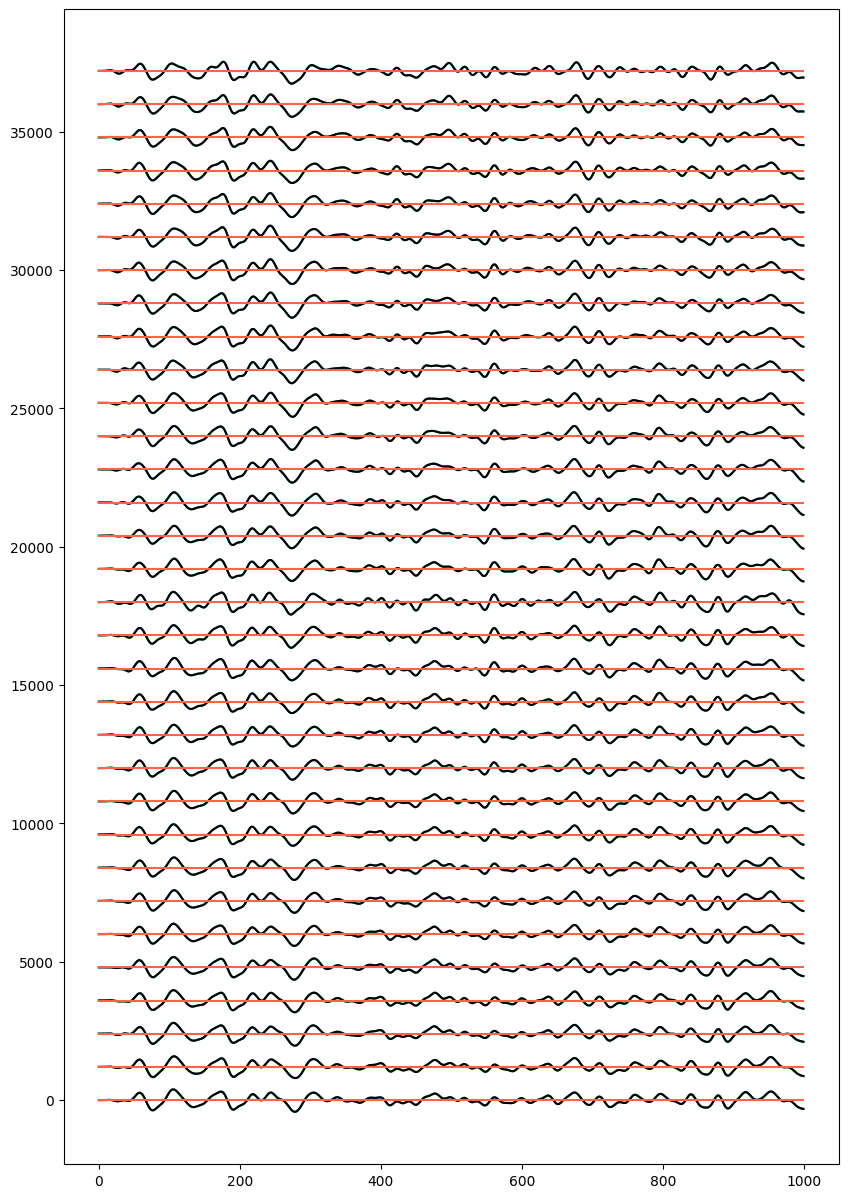

In [154]:
fig,ax = plt.subplots(figsize=(10,15))
ax.plot(YF.real.T+np.arange(0,32*1200,1200),color='teal')
ax.plot(analytical_signal[0].real.T+np.arange(0,32*1200,1200),color='k')
a=ax.plot(YF.imag.T+np.arange(0,32*1200,1200),color='tomato')

In [135]:
yf_conj = yf.conj()

In [136]:
YF = ifft(yf[0:N//2])
YF_CONJ = ifft(yf_conj[0:N//2])

In [137]:
YF.shape

(32, 1000)

In [158]:
inst_freq = YF[:,:-1]*YF_CONJ[:,1:] # instantaneous frequency of an analytical signal is the time derivative of phase arctan(Xn X*n+1) 

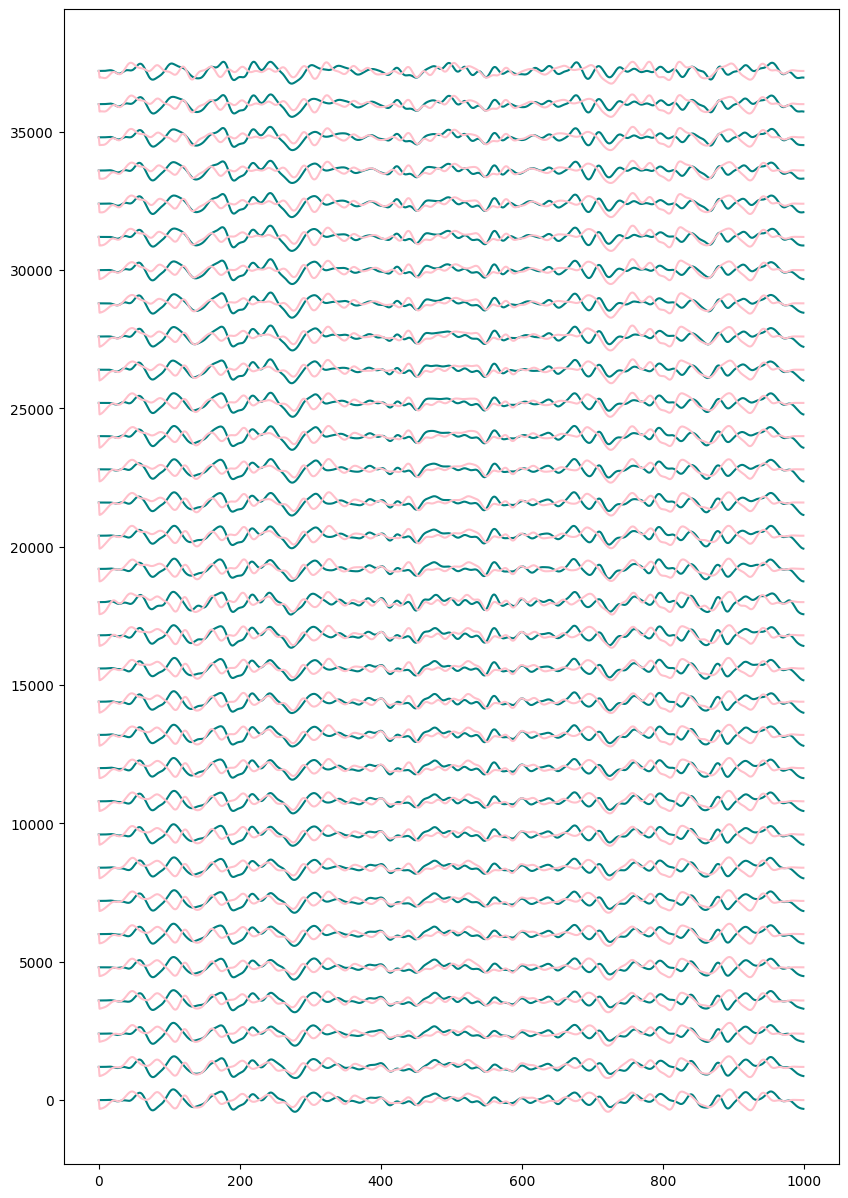

In [141]:
fig,ax = plt.subplots(figsize=(10,15))
a=ax.plot(YF.T+np.arange(0,32*1200,1200),color='teal')
a=ax.plot(YF_CONJ.T+np.arange(0,32*1200,1200),color='pink')

In [171]:
np.arctan(inst_freq[0]).shape

(999,)

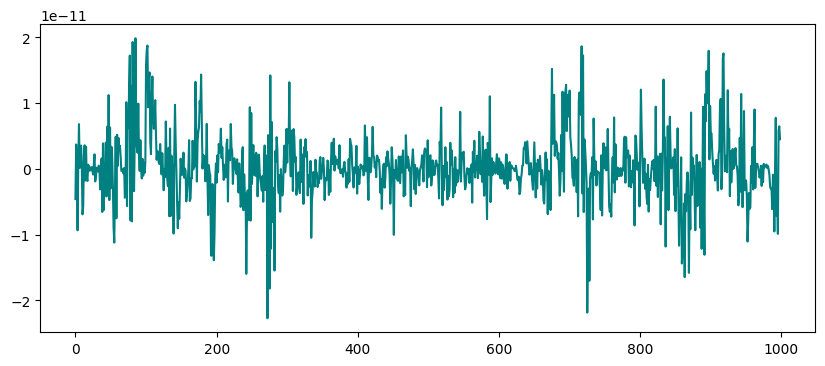

In [181]:
fig,ax = plt.subplots(figsize=(10,4))
a=ax.plot(inst_freq.imag[0],color='teal')


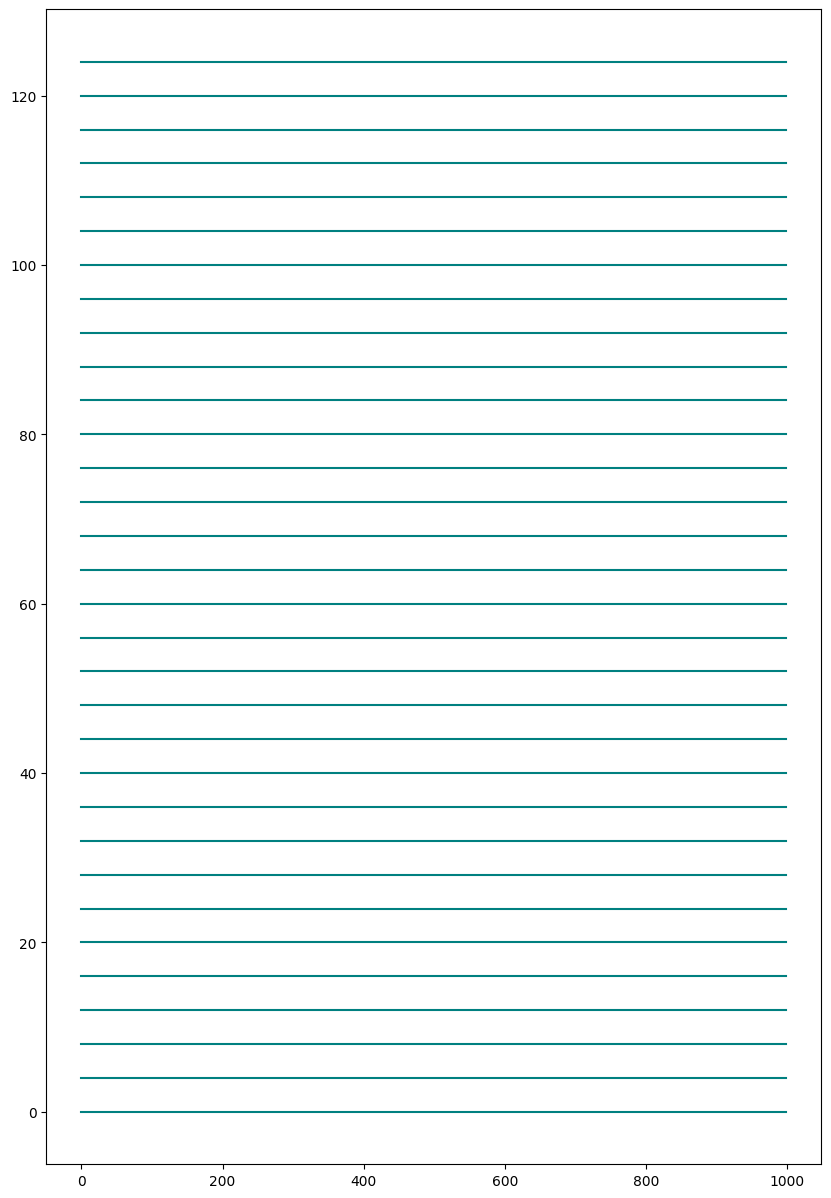

In [178]:
fig,ax = plt.subplots(figsize=(10,15))
a=ax.plot((inst_freq.imag).T+np.arange(0,32*4,4),color='teal')